<img src="https://github.com/Sengsathit/OCR_data_scientist_assets/blob/main/header_olist.png?raw=true" alt="Alternative text" />

**Table of contents**<a id='toc0_'></a>    
- [Introduction](#toc1_)    
- [Initialisation](#toc2_)    
- [Données de travail](#toc3_)    
  - [Fonctions ré-utilisables](#toc3_1_)    
  - [Chargement des données](#toc3_2_)    
    - [Extraction des données de la BDD](#toc3_2_1_)    
    - [Agrégation des données](#toc3_2_2_)    
    - [Sauvegarde du DataFrame de travail](#toc3_2_3_)    
- [Analyse exploratoire des données](#toc4_)    
  - [Aperçu global](#toc4_1_)    
  - [Les commandes](#toc4_2_)    
    - [Nombre de commandes par client](#toc4_2_1_)    
    - [Nombre de produits par commande](#toc4_2_2_)    
  - [Le panier moyen](#toc4_3_)    
  - [La satisfaction client](#toc4_4_)    
  - [RFM : Récence, Fréquence, Montant](#toc4_5_)    
    - [Récence](#toc4_5_1_)    
    - [Fréquence](#toc4_5_2_)    
    - [Montant](#toc4_5_3_)    
  - [Corrélations RFM et Satisfaction](#toc4_6_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

# <a id='toc1_'></a>[Introduction](#toc0_)

L'objectif de ce notebook est multiple :

- Extraction et agrégation des données de la base de données
- Feature engineering (création de nouveaux indicateurs)
- Analyse des indicateurs pertinents pour la segmentation des clients

# <a id='toc2_'></a>[Initialisation](#toc0_)

Importations et configurations

In [1]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Configurer Pandas pour un affichage complet du contenu des colonnes
# pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

plt.rcParams['figure.facecolor'] = '#FFFCF7'    # Définir la couleur de fond de la figure
plt.rcParams['axes.facecolor'] = '#FFFCF7'      # Définir la couleur de fond des axes

/var/folders/59/q0j81gmx5h7gvpg38k8hknzw0000gn/T/ipykernel_15342/1209071347.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


# <a id='toc3_'></a>[Données de travail](#toc0_)

## <a id='toc3_1_'></a>[Fonctions ré-utilisables](#toc0_)

Fonction d'extraction de données de la base de données

In [2]:
def get_data_from_db(
        script: str, 
        db_path: str) -> pd.DataFrame:
    
    """
    Exécute une requête SQL sur une base de données SQLite et retourne le résultat sous forme de DataFrame pandas.

    Args:
    script (str): La requête SQL à exécuter.
    db_path (str): Le chemin d'accès à la base de données SQLite.

    Returns:
    pd.DataFrame: Un DataFrame contenant les résultats de la requête SQL.
    """
    
    # Connexion à la base de données SQLite
    db_connexion = sqlite3.connect(db_path)
    
    # Exécution de la requête SQL et extraction des résultats dans un DataFrame
    df_extract = pd.read_sql(script, db_connexion)
    
    # Fermeture de la connexion à la base de données
    db_connexion.close()
    
    return df_extract

Fonction de concaténation de chaînes de caractères uniques

In [3]:
def unique_concat(values: str) -> str:
    
    """
    Combine une liste de chaînes de caractères en une seule chaîne avec des valeurs uniques triées.

    Args:
    values (str): Chaînes de caractères à combiner.

    Returns:
    str: Chaîne de caractères contenant les valeurs uniques, séparées par des virgules et triées par ordre alphabétique.
    """
    
    # Création d'un ensemble pour stocker les valeurs uniques
    unique_values = set()
    
    # Parcours de chaque chaîne dans la liste
    for val in values:
        # Séparation des éléments de la chaîne par des virgules et mise à jour de l'ensemble
        unique_values.update(val.split(','))
    
    # Retourne les valeurs uniques triées, jointes par une virgule
    return ','.join(sorted(unique_values))

Fonction de sélection des outliers dans une série

In [4]:
def get_outliers(
        data: pd.DataFrame, 
        feature: str) -> pd.Series:
    
    """
    Identifie les outliers dans une colonne spécifique d'un DataFrame.
    
    Parameters:
    data (pd.DataFrame): Le DataFrame contenant les données.
    feature (str): Le nom de la colonne pour laquelle identifier les outliers.
    
    Returns:
    pd.Series: Une série contenant les outliers.
    """
    # Calculer les quartiles et l'IQR
    q1 = data[feature].quantile(0.25)
    q3 = data[feature].quantile(0.75)
    iqr = q3 - q1

    # Définir les bornes pour les outliers
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr

    # Identifier les outliers
    outliers = data[(data[feature] < lower_bound) | (data[feature] > upper_bound)]
    
    return outliers

Fonction pour générer un boxplot d'une feature d'un DataFrame donné

In [5]:
def generate_boxplot(
        df_data: pd.DataFrame, 
        feature: str, 
        title:str, 
        x_label:str, 
        color: str = None,
        figsize: tuple = (20, 2),
        show_mean: bool = False,
        show_outliers: bool = True) -> None:
    
    """
    Génère un boxplot pour une colonne spécifique d'un DataFrame.

    Paramètres :
    df_data (pd.DataFrame) : Le DataFrame contenant les données.
    feature (str) : Le nom de la colonne à visualiser.
    title (str) : Le titre du graphique.
    x_label (str) : Le label de l'axe des abscisses.
    color (str, optionnel) : La couleur des boîtes du boxplot. Par défaut None.
    figsize (tuple, optionnel) : La taille de la figure. Par défaut (20, 2).
    show_mean (bool, optionnel) : Indique s'il faut afficher la moyenne. Par défaut False.
    show_outliers (bool, optionnel) : Indique s'il faut afficher les outliers. Par défaut True.

    Retour :
    None
    """
    
    plt.figure(figsize=figsize)
    sns.boxplot(data=df_data, x=feature, color=color, showfliers=show_outliers)
    plt.title(title, fontsize=16)
    plt.xlabel(x_label)

    # Calculer la moyenne et l'ajouter au graphique si spécifié
    if show_mean:
        mean_value = df_data[feature].mean()
        plt.axvline(mean_value, color='r', linestyle='--', linewidth=2)
        offset = (plt.xlim()[1] - plt.xlim()[0]) * 0.01
        plt.text(mean_value + offset, plt.ylim()[1] * 0.85, f'Moyenne: {mean_value:.2f}', color='r', ha='left') 
    
    plt.show()

Fonction pour générer un countplot d'une feature d'un Dataframe donné

In [6]:
def generate_countplot(
        df_data: pd.DataFrame, 
        feature: str, 
        title: str,
        x_label: str,
        y_label: str,
        figsize: tuple = (20, 6),
        color: str = None) -> None:
    
    """
    Génère un countplot pour une colonne spécifique d'un DataFrame avec des annotations de pourcentage.

    Paramètres :
    df_data (pd.DataFrame) : Le DataFrame contenant les données.
    feature (str) : Le nom de la colonne à visualiser.
    title (str) : Le titre du graphique.
    x_label (str) : Le label de l'axe x.
    y_label (str) : Le label de l'axe y.
    color (str, optionnel) : La couleur des barres du countplot. Par défaut None.
    figsize (tuple, optionnel) : La taille de la figure. Par défaut (20, 2).

    Retour :
    None
    """
    
    plt.figure(figsize=figsize)
    ax = sns.countplot(data=df_data, x=feature, color=color)

    # Calculer les pourcentages à afficher au dessus des barres
    total = len(df_data)
    for p in ax.patches:
        percentage = '{:.3f}%'.format(100 * p.get_height() / total)
        x = p.get_x() + p.get_width() / 2 - 0.05
        y = p.get_height() + 0.01 * total
        ax.annotate(percentage, (x, y), ha='center')

    ax.set_title(title, fontsize=16)
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    
    plt.show()

Fonction pour générer un histplot d'une feature d'un Dataframe donné

In [7]:
def generate_histplot(
        df_data: pd.DataFrame, 
        feature: str, 
        title: str, 
        x_label: str, 
        y_label: str, 
        color: str = None,
        figsize: tuple = (20, 6),
        bins: int = 50,
        show_kde: bool = False) -> None:
    
    """
    Génère un histogramme pour la caractéristique spécifiée dans le DataFrame.

    Paramètres :
    df_data (pd.DataFrame) : Le DataFrame contenant les données.
    feature (str) : La caractéristique/colonne à tracer.
    title (str) : Le titre du graphique.
    x_label (str) : Le label pour l'axe des x.
    y_label (str) : Le label pour l'axe des y.
    color (str, optionnel) : La couleur des barres de l'histogramme. Par défaut None.
    figsize (tuple, optionnel) : La taille de la figure. Par défaut (20, 6).
    show_kde (bool, optionnel) : Afficher la courbe KDE si True. Par défaut False.

    Retour :
    None
    """

    plt.figure(figsize=figsize)
    sns.histplot(data=df_data, x=df_data[feature], bins=bins, color=color, kde=show_kde, edgecolor='white')
    plt.title(title, fontsize=16)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.show()

## <a id='toc3_2_'></a>[Chargement des données](#toc0_)

### <a id='toc3_2_1_'></a>[Extraction des données de la BDD](#toc0_)

Les données des tables de la BDD sont chargées dans des DataFrames respectifs.

In [8]:
df_olist_reviews = get_data_from_db(script='SELECT * FROM order_reviews', db_path='../datasets/olist.db')   # Avis clients
df_olist_payments = get_data_from_db(script='SELECT * FROM order_pymts', db_path='../datasets/olist.db')    # Paiements
df_olist_sellers = get_data_from_db(script='SELECT * FROM sellers', db_path='../datasets/olist.db')         # Vendeurs
df_olist_items = get_data_from_db(script='SELECT * FROM order_items', db_path='../datasets/olist.db')       # Lignes de commande
df_olist_products = get_data_from_db(script='SELECT * FROM products', db_path='../datasets/olist.db')       # Produits
df_olist_orders = get_data_from_db(script='SELECT * FROM orders', db_path='../datasets/olist.db')           # Commandes
df_olist_customers = get_data_from_db(script='SELECT * FROM customers', db_path='../datasets/olist.db')     # Clients

### <a id='toc3_2_2_'></a>[Agrégation des données](#toc0_)

Les avis clients sont regroupés par commande, puis une moyenne des notes est calculée pour chaque commande.

In [9]:
df_reviews = df_olist_reviews.groupby('order_id').agg({'review_score': 'mean'}).reset_index()
df_reviews = df_reviews.loc[:, ~df_reviews.columns.str.contains('index')]

Les paiements sont regroupés par commande. Pour chaque commande, la somme des montants payés est calculée, et les types de paiement utilisés sont agrégés en une liste de types uniques.

In [10]:
df_payments = df_olist_payments.groupby('order_id').agg(
    payment_value=('payment_value', 'sum'),
    payment_types=('payment_type', lambda x: ','.join(map(str, x.unique())))
).reset_index()
df_payments = df_payments.loc[:, ~df_payments.columns.str.contains('index')]

Les lignes de commandes sont fusionnées avec les produits correspondants, puis regroupées par commande.

Pour chaque commande :
- les identifiants des produits sont agrégés en une liste unique
- les noms des catégories de produits sont agrégés en une liste unique
- le nombre total de produits est calculé
- les identifiants des vendeurs sont agrégés en une liste unique

In [11]:
df_items_products = df_olist_items.merge(df_olist_products, on='product_id', suffixes=('', '_product'))
df_items_products = df_items_products.groupby('order_id').agg(
    product_ids=('product_id', lambda x: ','.join(map(str, x.unique()))),
    product_categories=('product_category_name', lambda x: ','.join(map(str, x.unique()))),
    products_total=('product_id', 'count'),
    seller_ids=('seller_id', lambda x: ','.join(map(str, x.unique())))
).reset_index()
df_items_products = df_items_products.loc[:, ~df_items_products.columns.str.contains('index')]

Les informations sur les commandes sont fusionnées avec les avis clients, les paiements et les produits commandés, en utilisant l'identifiant de commande comme clé commune.\
Cette fusion permet de rassembler dans un seul DataFrame toutes les données associées à chaque commande, incluant les avis des clients, les détails des paiements et les informations sur les produits commandés.

In [12]:
df_orders = df_olist_orders.merge(df_reviews, on='order_id', suffixes=('', '_review'))\
                           .merge(df_payments, on='order_id', suffixes=('', '_payment'))\
                           .merge(df_items_products, on='order_id', suffixes=('', '_item'))
df_orders = df_orders.loc[:, ~df_orders.columns.str.contains('index')]

Les informations des clients sont fusionnées avec les données des commandes en utilisant l'identifiant du client (customer_id) comme clé commune.\
Ensuite, les dates d'achat des commandes sont converties en format de date et heure. Cela permet de rassembler toutes les informations liées aux clients et à leurs commandes, tout en s'assurant que les dates d'achat soient dans un format approprié pour une analyse temporelle.

In [13]:
df_customers = df_olist_customers.merge(df_orders, on='customer_id', suffixes=('', '_customer'))
df_customers['order_purchase_timestamp'] = pd.to_datetime(df_customers['order_purchase_timestamp'])
df_customers = df_customers.loc[:, ~df_customers.columns.str.contains('index')]

Les données des clients sont regroupées par identifiant unique, et diverses métriques sont calculées pour chaque client:
- la récence des commandes
- la fréquence des commandes
- le montant total dépensé
- le nombre total de commandes et de produits
- la moyenne de produits par commande
- le panier moyen
- les types de paiement utilisés
- le score moyen des avis
- les catégories de produits achetés
- les identifiants des vendeurs associés
- le nombre de catégories de produits achétés

In [14]:
reference_months = round((df_customers['order_purchase_timestamp'].max() - df_customers['order_purchase_timestamp'].min()).days/30)
reference_date = df_customers['order_purchase_timestamp'].max()

df = df_customers.groupby('customer_unique_id').agg(
    customer_zip_code_prefix=('customer_zip_code_prefix', 'first'),
    customer_state=('customer_state', 'first'),
    recency=('order_purchase_timestamp', lambda x: (reference_date - x.max()).days),
    frequency=('order_id', lambda x: round(x.nunique() * 1.0 / reference_months, 2)),
    monetary=('payment_value', 'sum'),
    orders_total=('order_id', 'count'),
    products_total=('products_total', 'sum'),
    products_per_order=('products_total', lambda x: round(x.sum() / x.count(), 2)),
    average_basket=('payment_value', lambda x: round(x.sum() / x.count(), 2)),
    payment_types=('payment_types', lambda x: ','.join(sorted(set(','.join(x).split(','))))),
    satisfaction=('review_score', lambda x: round(x.mean(), 2)),
    product_categories=('product_categories', lambda x: ','.join(sorted(set(','.join(x).split(','))))),
    seller_ids=('seller_ids', lambda x: ','.join(sorted(set(','.join(x).split(',')))))
).reset_index()
df['nb_product_categories'] = df['product_categories'].apply(lambda x: len(set(x.split(','))))
df = df.loc[:, ~df.columns.str.contains('index')]

### <a id='toc3_2_3_'></a>[Sauvegarde du DataFrame de travail](#toc0_)

In [15]:
df.to_csv('../datasets/olist.csv', index=False)

# <a id='toc4_'></a>[Analyse exploratoire des données](#toc0_)

## <a id='toc4_1_'></a>[Aperçu global](#toc0_)

Il existe 94 720 observations et donc autant de clients uniques dans le jeu de données.

In [16]:
df.shape

(94720, 15)

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 94720 entries, 0 to 94719
Data columns (total 15 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   customer_unique_id        94720 non-null  object 
 1   customer_zip_code_prefix  94720 non-null  int64  
 2   customer_state            94720 non-null  object 
 3   recency                   94720 non-null  int64  
 4   frequency                 94720 non-null  float64
 5   monetary                  94720 non-null  float64
 6   orders_total              94720 non-null  int64  
 7   products_total            94720 non-null  int64  
 8   products_per_order        94720 non-null  float64
 9   average_basket            94720 non-null  float64
 10  payment_types             94720 non-null  object 
 11  satisfaction              94720 non-null  float64
 12  product_categories        94720 non-null  object 
 13  seller_ids                94720 non-null  object 
 14  nb_pro

In [18]:
df.isna().any()

customer_unique_id          False
customer_zip_code_prefix    False
customer_state              False
recency                     False
frequency                   False
monetary                    False
orders_total                False
products_total              False
products_per_order          False
average_basket              False
payment_types               False
satisfaction                False
product_categories          False
seller_ids                  False
nb_product_categories       False
dtype: bool

## <a id='toc4_2_'></a>[Les commandes](#toc0_)

### <a id='toc4_2_1_'></a>[Nombre de commandes par client](#toc0_)

La quasi totalité des clients (+96%) n'ont effectué qu'une seule commande.

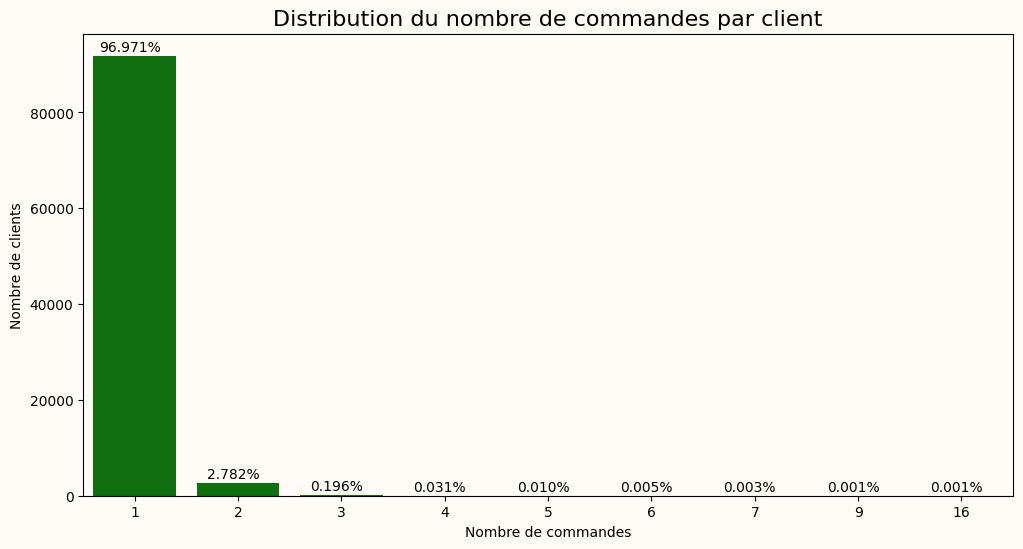

In [19]:
generate_countplot(
    df_data=df, 
    feature='orders_total', 
    title='Distribution du nombre de commandes par client', 
    x_label='Nombre de commandes', 
    y_label='Nombre de clients', 
    color='green',
    figsize=(12,6)
)

### <a id='toc4_2_2_'></a>[Nombre de produits par commande](#toc0_)

La quasi totalité des commandes ne comporte qu'un seul produit.

In [20]:
df['products_per_order'].describe()

count    94720.000000
mean         1.138260
std          0.522174
min          1.000000
25%          1.000000
50%          1.000000
75%          1.000000
max         21.000000
Name: products_per_order, dtype: float64

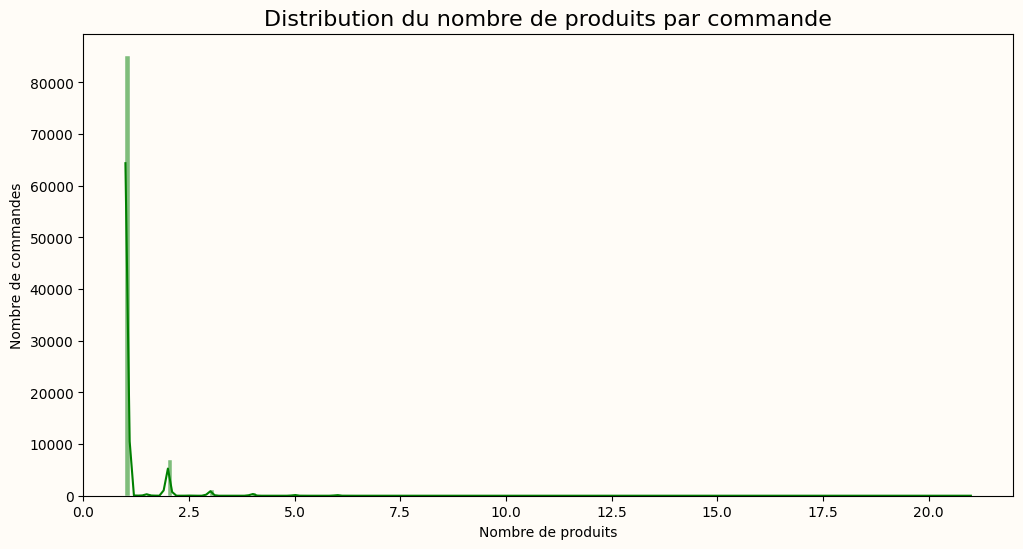

In [21]:
generate_histplot(
    df_data=df, 
    feature='products_per_order', 
    title='Distribution du nombre de produits par commande', 
    x_label='Nombre de produits', 
    y_label='Nombre de commandes', 
    color='green',
    figsize=(12,6),
    show_kde=True,
    bins=200
)

## <a id='toc4_3_'></a>[Le panier moyen](#toc0_)

Le panier moyen des clients a une valeur moyenne de 160.83 BRL.\
Il existe près de 7500 valeurs extrêmes pouvant amèner le panier moyen à +1000 BRL.\
La distribution des paniers moyens est fortement asymétrique, concentrée autour de faibles valeurs, avec une minorité de clients effectuant des achats beaucoup plus élevés.

In [22]:
df['average_basket'].describe()

count    94720.000000
mean       160.829613
std        219.979710
min          9.590000
25%         62.390000
50%        105.710000
75%        176.980000
max      13664.080000
Name: average_basket, dtype: float64

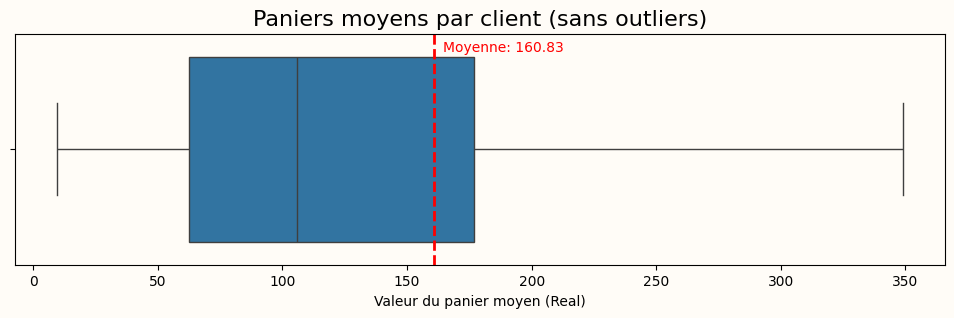

In [23]:
generate_boxplot(
    df_data=df, 
    feature='average_basket', 
    title='Paniers moyens par client (sans outliers)', 
    x_label='Valeur du panier moyen (Real)', 
    show_mean=True,
    show_outliers=False,
    figsize=(12,3)
)

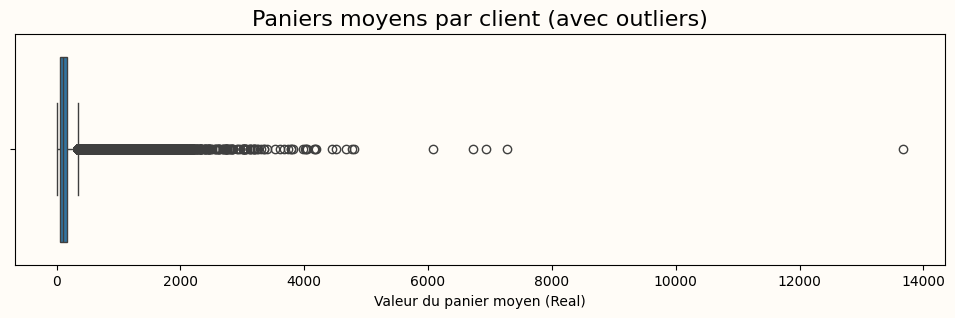

In [24]:
generate_boxplot(
    df_data=df, 
    feature='average_basket', 
    title='Paniers moyens par client (avec outliers)', 
    x_label='Valeur du panier moyen (Real)',
    figsize=(12,3)
)

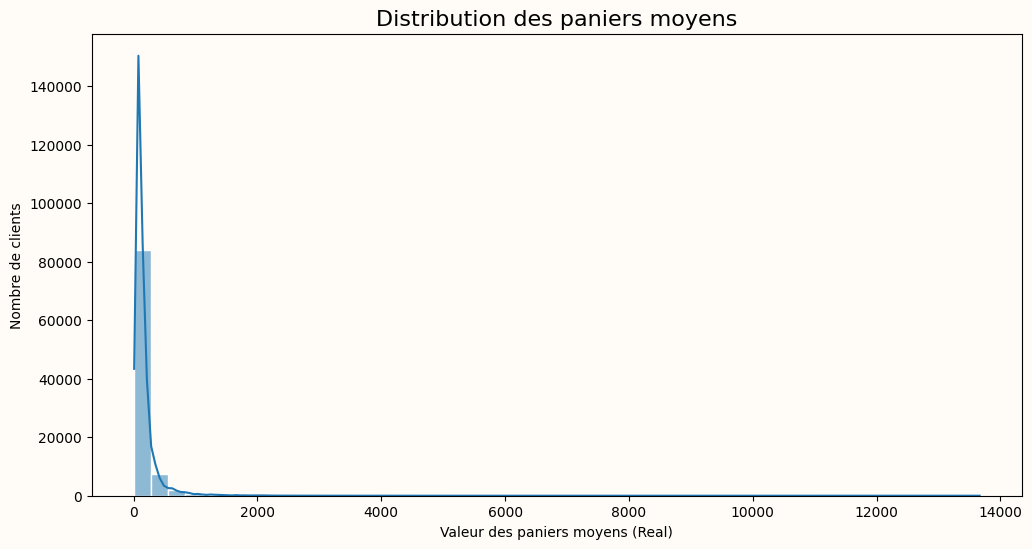

In [25]:
generate_histplot(
    df_data=df, 
    feature='average_basket', 
    title='Distribution des paniers moyens', 
    x_label='Valeur des paniers moyens (Real)', 
    y_label='Nombre de clients',
    show_kde=True,
    figsize=(12,6)
)

In [26]:
get_outliers(data=df, feature='average_basket').shape

(7482, 15)

## <a id='toc4_4_'></a>[La satisfaction client](#toc0_)

La satisfaction des clients se situe principalement dans les catégories "satisfait" à "très satisfait", malgré la présence de quelques clients très insatisfaits.
La satisfaction client semble même plutôt positive, 75% des avis est supérieur à 4.

In [27]:
df['satisfaction'].describe()

count    94720.000000
mean         4.102521
std          1.326359
min          1.000000
25%          4.000000
50%          5.000000
75%          5.000000
max          5.000000
Name: satisfaction, dtype: float64

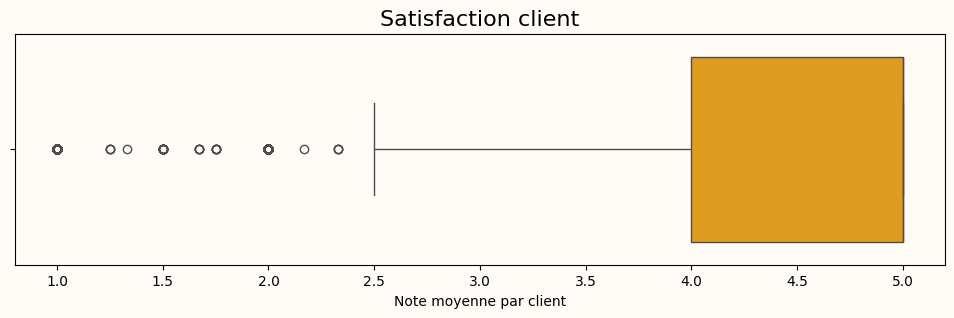

In [28]:
generate_boxplot(
    df_data=df, 
    feature='satisfaction', 
    title='Satisfaction client', 
    x_label='Note moyenne par client',
    color='orange',
    figsize=(12,3)
)

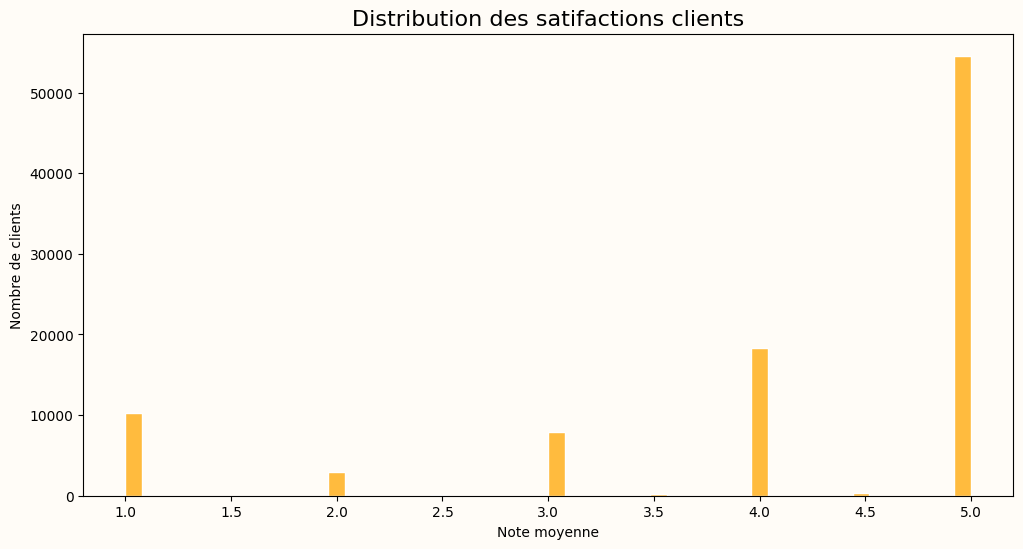

In [29]:
generate_histplot(
    df_data=df, 
    feature='satisfaction', 
    title='Distribution des satifactions clients', 
    x_label='Note moyenne', 
    y_label='Nombre de clients', 
    color='orange',
    figsize=(12,6)
)

## <a id='toc4_5_'></a>[RFM : Récence, Fréquence, Montant](#toc0_)

### <a id='toc4_5_1_'></a>[Récence](#toc0_)

Il existe une diversité dans la récence des achats. Une tendance générale à la baisse est observée après 300 jours, avec une diminution progressive du nombre de clients au fil du temps. Cela suggère que, bien que certains clients aient effectué des achats récents, une proportion significative de clients n'a pas effectué d'achats depuis longtemps.

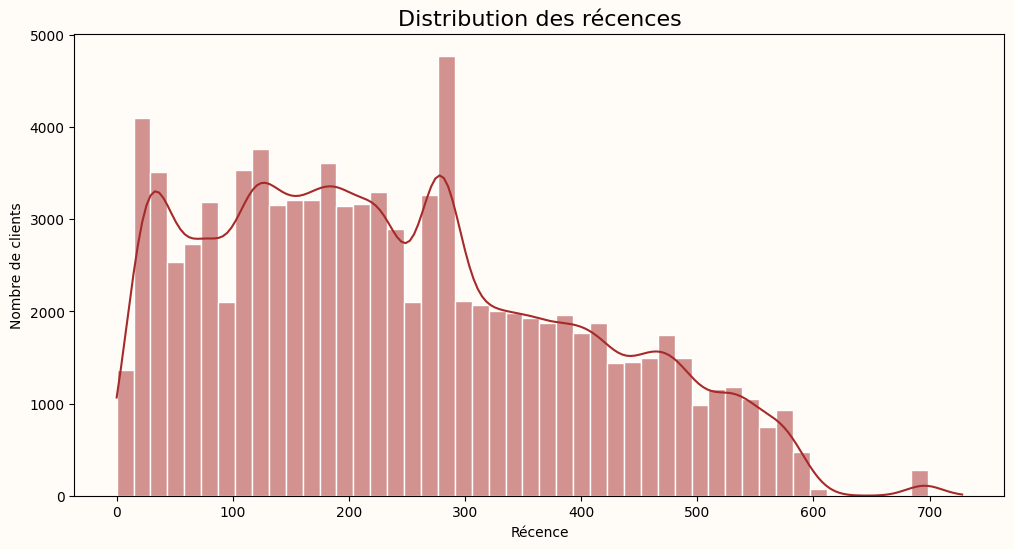

In [30]:
generate_histplot(
    df_data=df, 
    feature='recency', 
    title='Distribution des récences', 
    x_label='Récence', 
    y_label='Nombre de clients', 
    color='brown',
    figsize=(12,6),
    show_kde=True
)

### <a id='toc4_5_2_'></a>[Fréquence](#toc0_)

La quasi totalité des clients achètent très rarement (97%), avec une diminution rapide du nombre de clients pour des fréquences d'achat plus élevées.

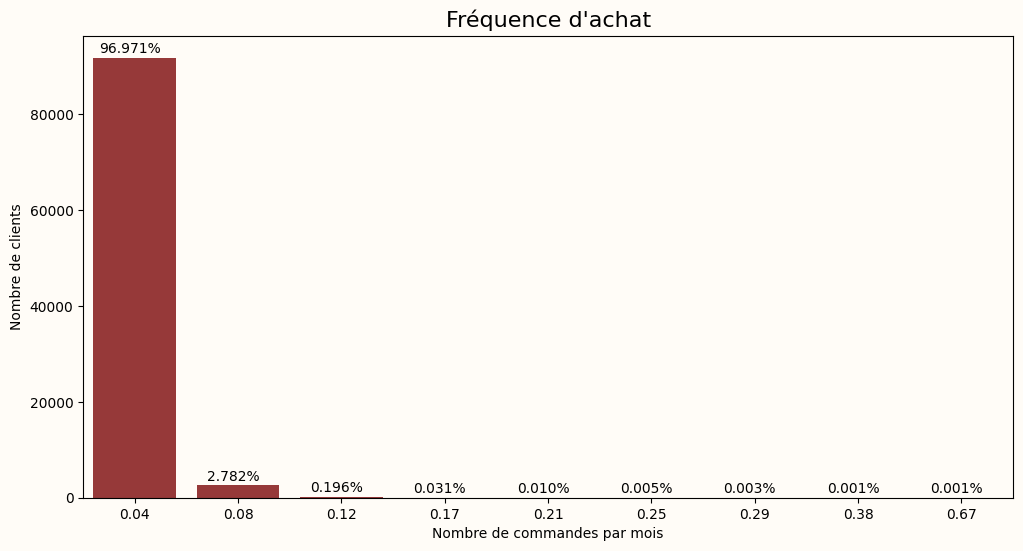

In [31]:
generate_countplot(
    df_data=df, 
    feature='frequency', 
    title='Fréquence d\'achat', 
    x_label='Nombre de commandes par mois', 
    y_label='Nombre de clients', 
    color='brown',
    figsize=(12,6)
)

### <a id='toc4_5_3_'></a>[Montant](#toc0_)

La majorité des clients dépensent de faibles montants, avec une fréquence décroissante rapide pour les montants plus élevés. Cette distribution est fortement asymétrique à droite ce qui indique qu'un petit nombre de clients dépensent des montants beaucoup plus élevés que la moyenne.

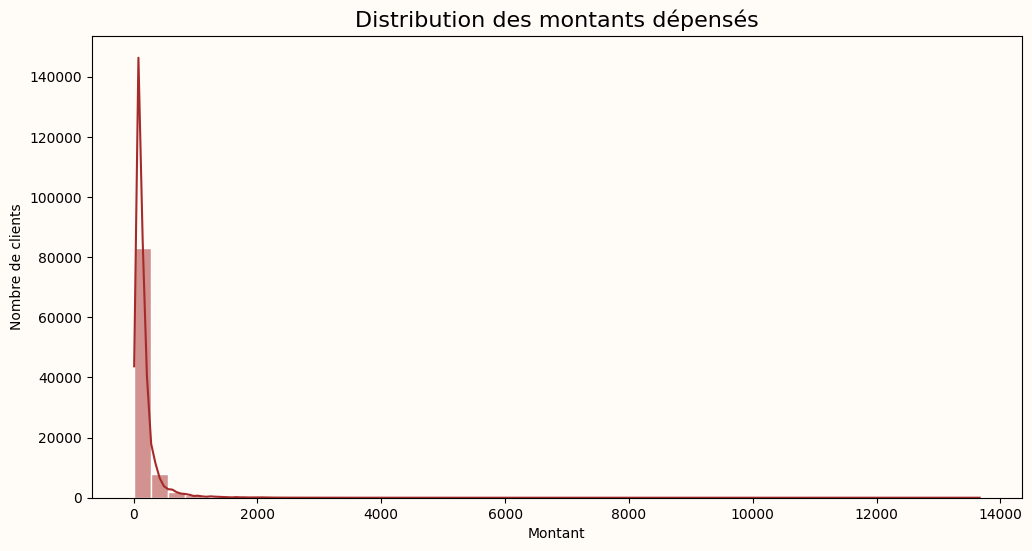

In [32]:
generate_histplot(
    df_data=df, 
    feature='monetary', 
    title='Distribution des montants dépensés', 
    x_label='Montant', 
    y_label='Nombre de clients', 
    color='brown',
    figsize=(12,6),
    show_kde=True
)

## <a id='toc4_6_'></a>[Corrélations RFM et Satisfaction](#toc0_)

Les résultats montrent des corrélations très faibles entre ces variables, avec la corrélation la plus élevée étant de 0.12 entre la fréquence et la valeur monétaire. Cela indique qu'il n'y a pas de relation significative entre les variables RFM et la satisfaction client dans cet ensemble de données.

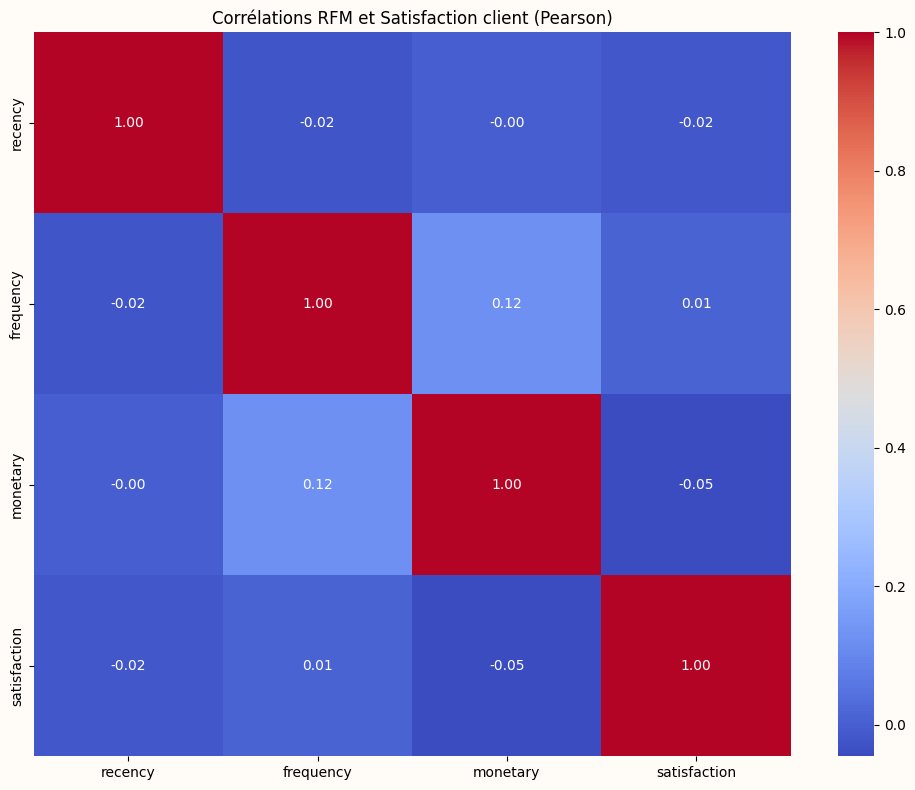

In [33]:
corr = df[[
    'recency', 
    'frequency', 
    'monetary', 
    'satisfaction']].corr(method="pearson")
plt.figure(figsize=(10, 8))
ax = sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm', cbar=True)
ax.set_title("Corrélations RFM et Satisfaction client (Pearson)")

plt.tight_layout()